In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load

In [2]:
filepath = "./accepted_2007_to_2018Q4.csv"
acc_df = pd.read_csv(filepath)

e:\kaggle\lending club\lendingclub\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
acc_df.shape

(2260701, 151)

In [4]:
pd.options.display.max_rows = 200

In [5]:
acc_df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

### Prepare dataset (Choose a subset of independent variables, Split X and y)

In [6]:
acc_df = acc_df.loc[acc_df['loan_status'].isin(["Fully Paid", "Charged Off"])]
acc_df.shape

(1345310, 151)

In [7]:
independent_variables =['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_title','emp_length',
        'home_ownership','annual_inc','verification_status','issue_d','purpose',
        'title','dti','earliest_cr_line','open_acc','pub_rec','revol_bal','revol_util',
        'total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies']
X = acc_df[independent_variables]
y = acc_df["loan_status"]
del acc_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
del X, y

### Preliminary Data Preprocessing (Remove columns that has more than 20 percent missing values)

In [8]:
# acc_df.info(verbose=True, show_counts=True)
null_perc_table = X_train.isnull().mean() * 100
null_perc_table

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               6.400437
emp_length              5.855899
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
purpose                 0.000000
title                   1.231793
dti                     0.028352
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.062758
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                3.532059
pub_rec_bankruptcies    0.051714
dtype: float64

In [9]:
# Column with more than 20 percent missing values
null_perc_table_20_bool = null_perc_table > 20
print(null_perc_table_20_bool.value_counts())

False    25
dtype: int64


In [10]:
## Drop columns that have more than 20 percent null values
# Drop if there is column with more than 20 percent missing values
if null_perc_table_20_bool.any():
    col_to_drop = null_perc_table_20_bool[null_perc_table_20_bool].keys()
    col_to_drop = col_to_drop.append(pd.Index(['id']))
    X_train = X_train.drop(col_to_drop, axis=1)
    X_test = X_test.drop(col_to_drop, axis=1)
print(X_train.shape)

(941717, 25)


## Initial Data Exploration

In [11]:
categorical_col = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_col = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Number of categorical variables:", len(categorical_col))
print("Number of numerical variables:", len(numerical_col))
print("Number of unique values for each categorical variables \n", X_train[categorical_col].nunique())
print("Categorical Variables \n", categorical_col)
print("Numerical Variables \n", numerical_col)

Number of categorical variables: 13
Number of numerical variables: 12
Number of unique values for each categorical variables 
 term                        2
grade                       7
sub_grade                  35
emp_title              284067
emp_length                 11
home_ownership              6
verification_status         3
issue_d                   139
purpose                    14
title                   45466
earliest_cr_line          734
initial_list_status         2
application_type            2
dtype: int64
Categorical Variables 
 ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'title', 'earliest_cr_line', 'initial_list_status', 'application_type']
Numerical Variables 
 ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']


<AxesSubplot:>

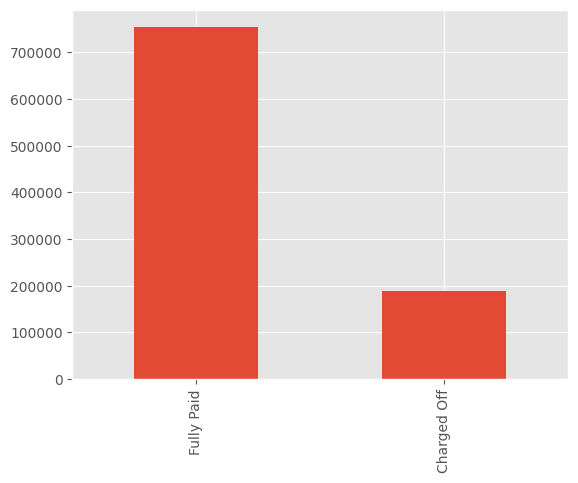

In [12]:
plt.style.use('ggplot')
y_train.value_counts().plot.bar()

## Feature Engineering

In [13]:
# Drop the emp_title column as there are too many unique job titles for one hot encoding
X_train.drop('emp_title', axis=1, inplace=True)
X_test.drop('emp_title', axis=1, inplace=True)
X_train.drop('title', axis=1, inplace=True)
X_test.drop('title', axis=1, inplace=True)
# This would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our
# model, so in theory we wouldn't have an issue_date, drop this feature.
X_train.drop('issue_d', axis=1, inplace=True)
X_test.drop('issue_d', axis=1, inplace=True)

In [14]:
# Convert nominal variable to numerical values
print(X_train.emp_length.unique())
X_train['emp_length'].replace(['< 1 year', '1 year','2 years','3 years','4 years','5 years',
'6 years', '7 years', '8 years','9 years','10+ years'], [0,1,2,3,4,5,6,7,8,9,10], inplace=True)
X_test['emp_length'].replace(['< 1 year', '1 year','2 years','3 years','4 years','5 years',
'6 years', '7 years', '8 years','9 years','10+ years'], [0,1,2,3,4,5,6,7,8,9,10], inplace=True)
print(X_train.emp_length.unique())

['10+ years' '1 year' '2 years' '6 years' nan '3 years' '< 1 year'
 '9 years' '8 years' '7 years' '5 years' '4 years']
[10.  1.  2.  6. nan  3.  0.  9.  8.  7.  5.  4.]


In [15]:
# We know that grade is just a sub feature of sub_grade, So we are goinig to drop it.
X_train.drop('grade', axis=1, inplace=True)
X_test.drop('grade', axis=1, inplace=True)
print(X_train.sub_grade.unique())
X_train['sub_grade'].replace(["A1","A2","A3","A4","A5",
                               "B1","B2","B3","B4","B5",
                               "C1","C2","C3","C4","C5",
                               "D1","D2","D3","D4","D5",
                               "E1","E2","E3","E4","E5",
                               "F1","F2","F3","F4","F5",
                               "G1","G2","G3","G4","G5"],

                               [0,1,2,3,4,
                               5,6,7,8,9,
                               10,11,12,13,14,
                               15,16,17,18,19,
                               20,21,22,23,24,
                               25,26,27,28,29,
                               30,31,32,33,34], inplace=True)
X_test['sub_grade'].replace(["A1","A2","A3","A4","A5",
                               "B1","B2","B3","B4","B5",
                               "C1","C2","C3","C4","C5",
                               "D1","D2","D3","D4","D5",
                               "E1","E2","E3","E4","E5",
                               "F1","F2","F3","F4","F5",
                               "G1","G2","G3","G4","G5"],

                               [0,1,2,3,4,
                               5,6,7,8,9,
                               10,11,12,13,14,
                               15,16,17,18,19,
                               20,21,22,23,24,
                               25,26,27,28,29,
                               30,31,32,33,34], inplace=True)
print(X_train.sub_grade.unique())

['D2' 'B5' 'B4' 'C1' 'C5' 'C4' 'F1' 'D1' 'A3' 'B1' 'E1' 'B3' 'G4' 'A4'
 'C2' 'D3' 'C3' 'A2' 'D4' 'A5' 'B2' 'E3' 'E5' 'D5' 'E4' 'E2' 'F5' 'A1'
 'F4' 'G3' 'F3' 'F2' 'G2' 'G5' 'G1']
[16  9  8 10 14 13 25 15  2  5 20  7 33  3 11 17 12  1 18  4  6 22 24 19
 23 21 29  0 28 32 27 26 31 34 30]


### Convert date from format month year to year

In [16]:
X_train['earliest_cr_line'] = pd.to_datetime(X_train['earliest_cr_line'])
X_test['earliest_cr_line'] = pd.to_datetime(X_test['earliest_cr_line'])
X_train['earliest_cr_line'] = X_train.earliest_cr_line.dt.year
X_test['earliest_cr_line'] = X_test.earliest_cr_line.dt.year

In [17]:
categorical_col = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_col = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Number of categorical variables:", len(categorical_col))
print("Number of numerical variables:", len(numerical_col))
print("Number of unique values for each categorical variables \n", X_train[categorical_col].nunique())
print("Categorical Variables \n", categorical_col)
print("Numerical Variables \n", numerical_col)

Number of categorical variables: 6
Number of numerical variables: 15
Number of unique values for each categorical variables 
 term                    2
home_ownership          6
verification_status     3
purpose                14
initial_list_status     2
application_type        2
dtype: int64
Categorical Variables 
 ['term', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']
Numerical Variables 
 ['loan_amnt', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']


In [18]:
X_train.head().T
# acc_df.describe().T

,37505,1981912,663165,133637,512113
loan_amnt,4000.0,5400.0,12000.0,3500.0,16500.0
term,36 months,36 months,36 months,36 months,36 months
int_rate,16.55,11.49,10.75,12.29,16.02
installment,141.72,178.05,391.45,116.74,580.26
sub_grade,16,9,8,10,14
emp_length,10.0,1.0,1.0,10.0,10.0
home_ownership,MORTGAGE,MORTGAGE,RENT,MORTGAGE,MORTGAGE
annual_inc,57000.0,33280.0,50000.0,72000.0,83000.0
verification_status,Verified,Source Verified,Verified,Verified,Source Verified
purpose,home_improvement,credit_card,debt_consolidation,home_improvement,debt_consolidation


### Drop 0 variance numerical features 

In [19]:
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(X_train[numerical_col])
constant_columns = [column for column in X_train[numerical_col].columns
                    if column not in X_train[numerical_col].columns[var_thres.get_support()]]
print(constant_columns)
print(len(constant_columns))
X_train = X_train.drop(constant_columns, axis=1)
X_test = X_test.drop(constant_columns, axis=1)
# Remove the contant_columns from numerical_col
for i in constant_columns:
    numerical_col.remove(i)

[]
0


### Univariate Analysis

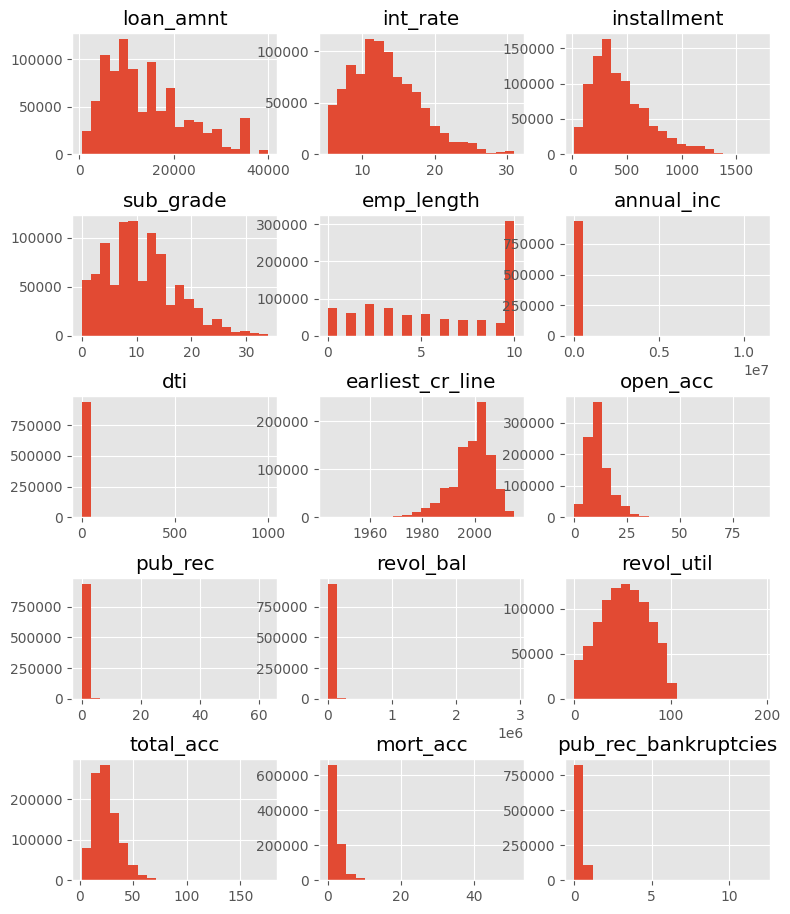

In [20]:
def numerical_plot(X: pd.DataFrame, y=None, chart='hist') -> None:
    """Plot for numerical variables

    Args:
        X (pd.DataFrame): independent variables
        y (pd.Series): dependent variables
        chart (str): hist or boxplot
  
    Returns:
        None
    """
    assert isinstance(X, pd.DataFrame)
    plt.figure(figsize=(9, 11))
    plt.subplots_adjust(hspace=0.5)
    # set number of columns (use 3 to demonstrate the change)
    ncols = 3
    # calculate number of rows
    nrows = len(numerical_col) // ncols + (len(numerical_col) % ncols > 0)

    # loop through the length of tickers and keep track of index
    for n, numerical_var in enumerate(numerical_col):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, n + 1)

        # filter df and plot ticker on the new subplot axis
        if chart == 'hist':
            ax.hist(X[numerical_var], bins=20)
        elif chart == "boxplot":
            assert isinstance(y, pd.Series)
            sns.boxplot(x = y, y = X[numerical_var], hue = y)   
        else:
            return 0

        # chart formatting
        ax.set_title(numerical_var)
        if ax.get_legend():
            ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")

numerical_plot(X_train, None, chart="hist")


### Multivariate Analysis

#### Correlation Matrix

<AxesSubplot:>

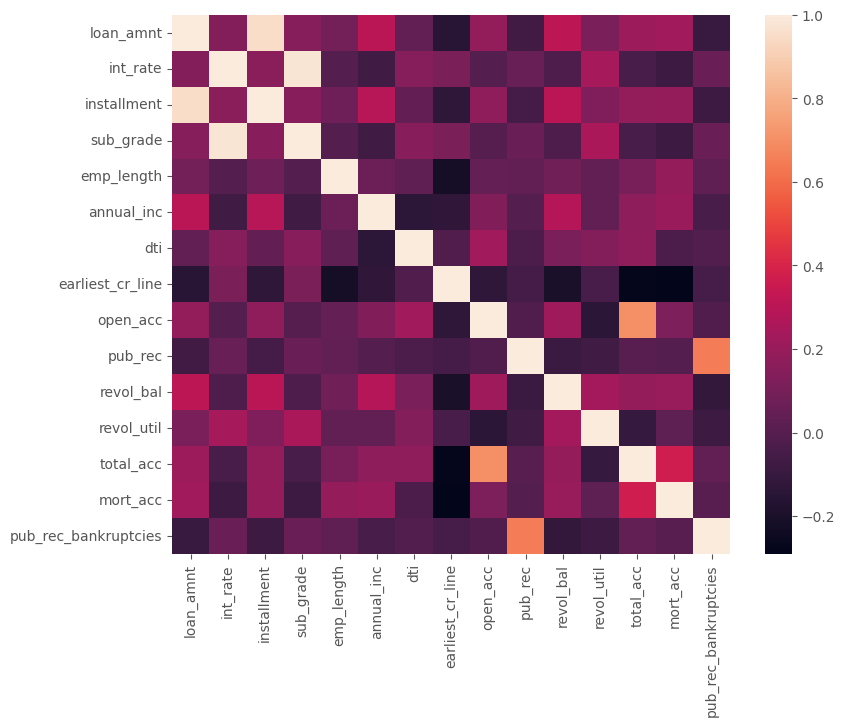

In [21]:
plt.figure(figsize=(9, 7))
sns.heatmap(X_train.corr())

In [22]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    row_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                rowname = corr_matrix.columns[j]  # getting the name of row
                col_corr.append(colname)
                row_corr.append(rowname)
    return col_corr, row_corr

number of high correlation features: 2
{'installment', 'sub_grade'}


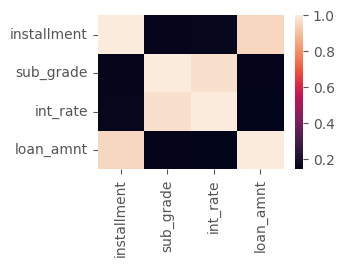

In [23]:
corr_features_col, corr_features_row = correlation(X_train, 0.9)
corr_features_col_set, corr_features_row_set = set(corr_features_col), set(corr_features_row)
print("number of high correlation features:", len(corr_features_col_set))
print(corr_features_col_set)
# Correlation of highly correlated features only
if len(set(corr_features_col))>0:
    plt.figure(figsize=(3, 2))
    sns.heatmap(X_train[corr_features_col_set.union(corr_features_row_set)].corr())

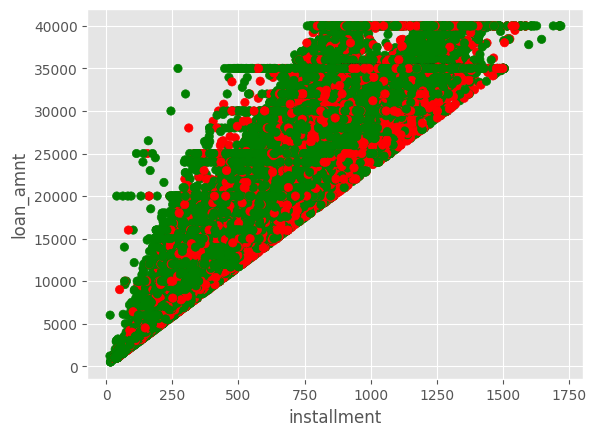

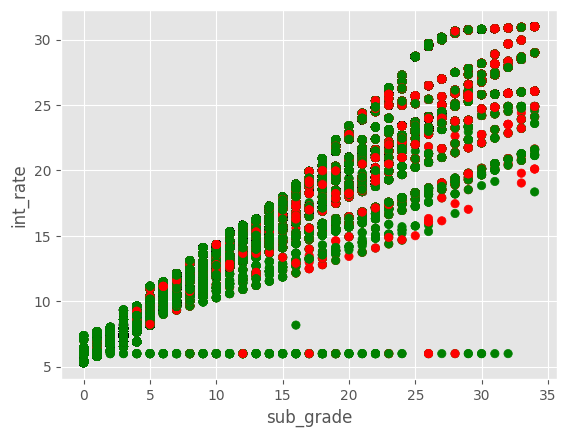

In [24]:
colors = {'Charged Off':'red', 'Fully Paid':'green'}
for i in range(len(corr_features_col)):
    plt.scatter(X_train[corr_features_col[i]], X_train[corr_features_row[i]], c=y_train.map(colors))
    plt.xlabel(corr_features_col[i])
    plt.ylabel(corr_features_row[i])
    plt.show()

#### Bivariate Boxplot

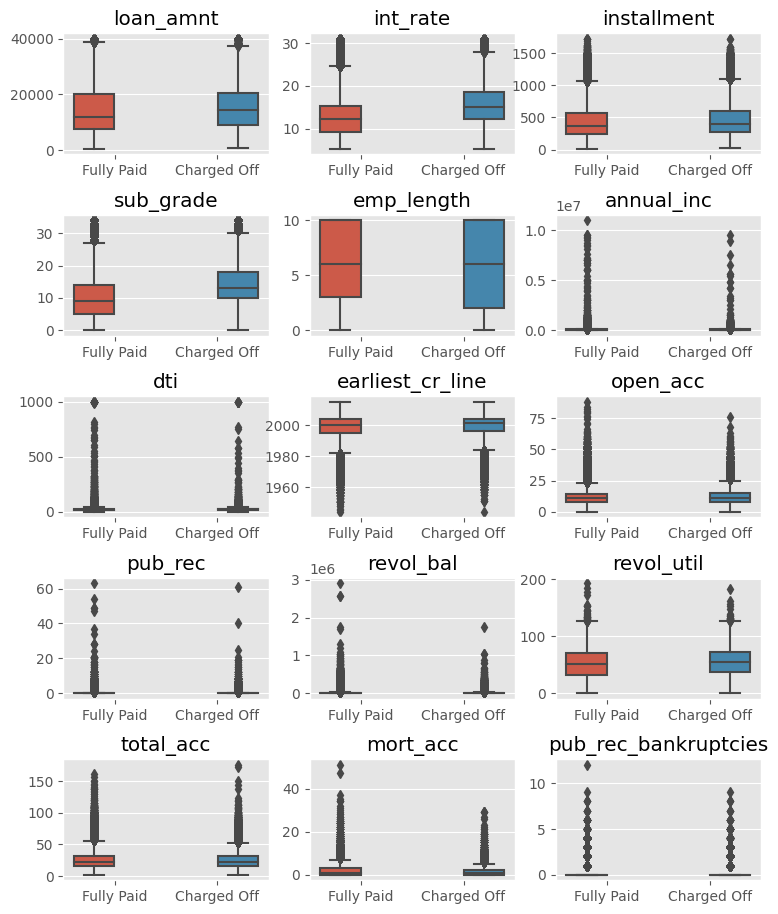

In [25]:
numerical_plot(X_train, y_train, chart="boxplot")

### Handle Outlier

In [26]:
def outlier_perc(values: pd.Series):
    """Calculate the percentage of outlier of the column

    Args:
        values (pd.Series): one of the column of independent variables to be analysed
  
    Returns:
        float: percentage of outlier
    """
    assert isinstance(values, pd.Series)
    Q1, Q3 = np.quantile(values, [0.25,0.75])
    IQR = Q3 - Q1
    val_outlier_lower = values[values < (Q1 - 1.5 * IQR)]
    val_outlier_upper = values[values > (Q3 + 1.5 * IQR)]
    val_outlier = pd.concat([val_outlier_lower,val_outlier_upper],axis=1)
    return len(val_outlier)/len(values)

for n, numerical_var in enumerate(numerical_col):
    outlier_percentage = outlier_perc(X_train[numerical_var])
    print(numerical_var, outlier_percentage)

loan_amnt 0.00529776992451023
int_rate 0.018445031787681438
installment 0.03125355069516638
sub_grade 0.0177356891720124
emp_length 0.0
annual_inc 0.04899348742775165
dti 0.0
earliest_cr_line 0.03058243612465316
open_acc 0.03415569645657878
pub_rec 0.16961358879578473
revol_bal 0.05920568493507073
revol_util 0.0
total_acc 0.01678211182340342
mort_acc 0.0
pub_rec_bankruptcies 0.0


### Handle Categorical Variables

#### Chisquare Test

In [27]:
def chi2test(var1, var2, verbose=False):
    contigency= pd.crosstab(var1, var2) 
    c, p_value, dof, expected = chi2_contingency(contigency)
    return p_value, contigency, expected

In [28]:
X_train = pd.get_dummies(X_train, columns=categorical_col, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_col, drop_first=True)
#get column names that were not in the original dataframe
new_cols = X_train.columns[~X_train.columns.isin(categorical_col+numerical_col)]
for variable in new_cols:
    p_value, contigency, expected = chi2test(X_train[variable], y_train)
    if p_value > 0.05:
        print(variable, p_value)
        # print(contigency)
        # print(expected)

home_ownership_NONE 0.48191397728614027
home_ownership_OTHER 0.8352317374626859
purpose_educational 0.2815466277202549
purpose_vacation 0.14214888156360178


### Handle Missing Values 

#### Drop row with less than 1 percent missing percentage

In [29]:
# df.dropna(subset = ['column_name'])
def dropNaRows(dataX: pd.DataFrame, dataY: pd.Series, null_perc_table: pd.Index,  y_column_names: str, perc_drop=1):
    dataX.insert(0, y_column_names, dataY)
    data = dataX
    for column, null_perc in zip(null_perc_table.index, null_perc_table):
        if null_perc < perc_drop and null_perc > 0:
            data.dropna(subset = [column], inplace=True)
    return data[y_column_names], data.drop(columns=y_column_names)
y_train, X_train = dropNaRows(X_train, y_train, null_perc_table, y_column_names="loan_status")

#### Mice Imputation

In [30]:
scaler = MinMaxScaler()
column_names = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), imputation_order='ascending',  random_state= 42)
X_train_imputed_name = "X_train_imputed.pkl"
X_test_imputed_name = "X_test_imputed.pkl"

if not os.path.isfile(X_train_imputed_name): 
    X_train_imputed = pd.DataFrame(mice_imputer.fit_transform(X_train), columns=column_names)
    X_test_imputed = pd.DataFrame(mice_imputer.transform(X_test), columns=column_names)
    dump(X_train_imputed, X_train_imputed_name)
    dump(X_test_imputed, X_test_imputed_name)
else:
    X_train_imputed = load(X_train_imputed_name)
    X_test_imputed = load(X_test_imputed_name)


### Random Forest Model

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV 
import scipy
import os.path
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

param_grid = {'n_estimators': np.arange(50,200,15),
              'max_features': np.arange(0.1, 1, 0.1),
              'max_depth': scipy.stats.randint(10, 100),
              'max_samples': [0.3, 0.5, 0.8]}

rf_model_name = "rf_model.pkl"
if not os.path.isfile(rf_model_name): 
    model = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced_subsample'), param_grid, cv = 3, n_iter = 15, random_state=0, n_jobs=-1).fit(X_train_imputed, y_train) # 165 mins
    dump(model, 'rf_model.pkl')
else:
    model = load(rf_model_name)
rf_clf = model.best_estimator_
# rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1) # 3 min 19 s
# rf_clf.fit(X_train_imputed, y_train)

In [123]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)

def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [124]:
y_train_pred = rf_clf.predict(X_train_imputed)
y_test_pred = rf_clf.predict(X_test_imputed)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 94.29%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.999828       0.933401  0.942871       0.966615   
recall          0.713952       0.999969  0.942871       0.856961   
f1-score        0.833047       0.965539  0.942871       0.899293   
support    187731.000000  752642.000000  0.942871  940373.000000   

            weighted avg  
precision       0.946662  
recall          0.942871  
f1-score        0.939089  
support    940373.000000  
_______________________________________________
Confusion Matrix: 
 [[134031  53700]
 [    23 752619]]

Test Result:
Accuracy Score: 80.21%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.539570       0.808146  0.802142       0.673858       0.754531
recall         0.060421       0.987140  0.80214

### ANN Model

In [133]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
# import tensorflow.keras.backend as K
import tensorflow_addons as tfa

# def get_f1(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

def get_nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=1, threshold=0.5, average="macro")])
    return model

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['f1_score'], label='f1_score')
    plt.plot(r.history['val_f1_score'], label='val_f1_score')
    plt.title('AUC score evolution during trainig')
    plt.legend()

In [126]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

num_columns = X_train_imputed.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 0.001


nn_model = get_nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
class_weight = {0: class_weights[0], 1: class_weights[1]}
nn_model_name = "nn_model"
if not os.path.isfile(nn_model_name): 
    r = nn_model.fit(
        np.array(X_train_imputed), y_train,
        validation_data=(np.array(X_test_imputed), y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping], 
        verbose=1,
        class_weight=class_weight
    )
    nn_model.save(nn_model_name)
else:
    nn_model = tf.keras.models.load_model('path/to/location')

Epoch 1/50
29387/29387 [==============================] - 193s 6ms/step - loss: 0.6327 - f1_score: 0.7297 - val_loss: 0.6268 - val_f1_score: 0.7546
Epoch 2/50
29387/29387 [==============================] - 178s 6ms/step - loss: 0.6271 - f1_score: 0.7347 - val_loss: 0.6272 - val_f1_score: 0.7382
Epoch 3/50
29387/29387 [==============================] - 179s 6ms/step - loss: 0.6260 - f1_score: 0.7343 - val_loss: 0.6200 - val_f1_score: 0.7478
Epoch 4/50
29387/29387 [==============================] - 177s 6ms/step - loss: 0.6256 - f1_score: 0.7333 - val_loss: 0.6127 - val_f1_score: 0.7475
Epoch 5/50
29387/29387 [==============================] - 169s 6ms/step - loss: 0.6251 - f1_score: 0.7331 - val_loss: 0.6156 - val_f1_score: 0.7622
Epoch 6/50
29387/29387 [==============================] - 172s 6ms/step - loss: 0.6249 - f1_score: 0.7327 - val_loss: 0.6046 - val_f1_score: 0.7520
Epoch 7/50
29387/29387 [==============================] - 170s 6ms/step - loss: 0.6243 - f1_score: 0.7339 - val_

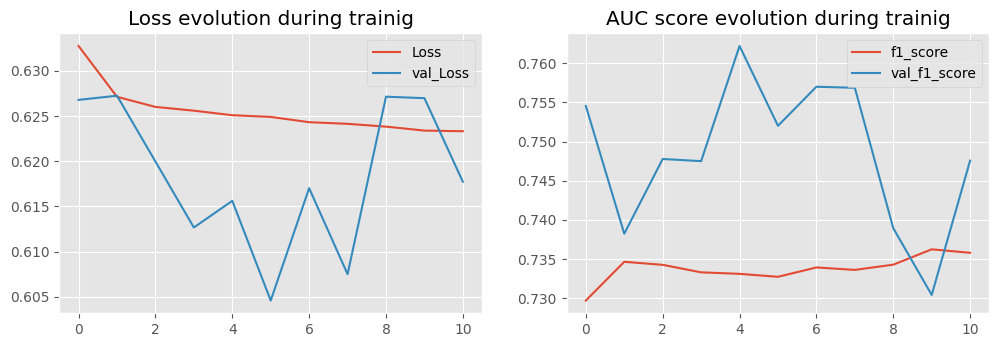

In [131]:
plot_learning_evolution(r)

In [127]:
y_train_pred = nn_model.predict(X_train_imputed)
print_score(y_train, y_train_pred.round(), train=True)
y_test_pred = nn_model.predict(X_test_imputed)
print_score(y_test, y_test_pred.round(), train=False)

29387/29387 [==============================] - 56s 2ms/step
Train Result:
Accuracy Score: 65.16%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.320850       0.886452  0.651574       0.603651   
recall          0.667418       0.647623  0.651574       0.657520   
f1-score        0.433367       0.748446  0.651574       0.590907   
support    187731.000000  752642.000000  0.651574  940373.000000   

            weighted avg  
precision       0.773538  
recall          0.651574  
f1-score        0.685546  
support    940373.000000  
_______________________________________________
Confusion Matrix: 
 [[125295  62436]
 [265214 487428]]

12613/12613 [==============================] - 24s 2ms/step
Test Result:
Accuracy Score: 65.06%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precis

# Remove Outlier